In [1]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers


In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))
    model = effnet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(3,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

    
    return model

def modelSummary(model):
    model.summary()


In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)
    checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    
    return model, annealer, checkpoint

In [6]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 32):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history


In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:


def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - DenseNet201.h5")
    print("Model Saved!")

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")




Total :  Found 15000 files belonging to 3 classes.


2022-12-26 19:07:18.854713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 19:07:19.008547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 19:07:19.009422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 19:07:19.012503: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil


For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']


2022-12-26 19:07:24.587115: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Image Shape :  (32, 256, 256, 3)
16719872/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]           

2022-12-26 19:07:38.473304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


329/329 [==============================] - 148s 407ms/step - loss: 0.1274 - accuracy: 0.9576 - val_loss: 0.6561 - val_accuracy: 0.8364

Epoch 00001: val_accuracy improved from -inf to 0.83644, saving model to effnet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
329/329 [==============================] - 96s 290ms/step - loss: 0.0546 - accuracy: 0.9819 - val_loss: 0.0750 - val_accuracy: 0.9780

Epoch 00002: val_accuracy improved from 0.83644 to 0.97800, saving model to effnet.h5
Epoch 3/7
329/329 [==============================] - 96s 293ms/step - loss: 0.0541 - accuracy: 0.9822 - val_loss: 0.0409 - val_accuracy: 0.9869

Epoch 00003: val_accuracy improved from 0.97800 to 0.98689, saving model to effnet.h5
Epoch 4/7
329/329 [==============================] - 97s 293ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.0152 - val_accuracy: 0.9956

Epoch 00004: val_accuracy improved from 0.98689 to 0.99556, saving model to effnet.h5
Epoch 5/7
329/329 [==============================] - 96s 291ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0179 - val_accuracy: 0.9951

Epoch 00005: val_accuracy did not improve from 0.99556
Epoch 6/7
329/329 [==============================] - 95s 290ms/step - loss: 0.0218 - accuracy: 0.9941 - val

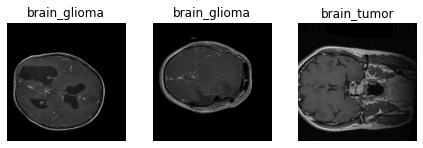

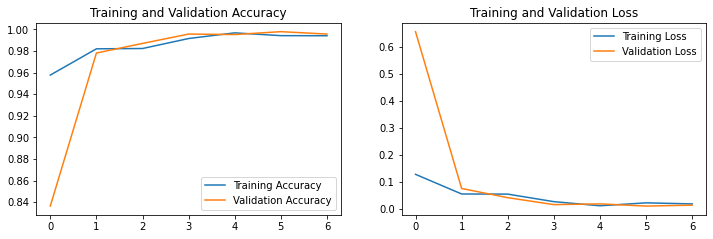

141/141 [==============================] - 21s 151ms/step - loss: 0.0132 - accuracy: 0.9956
Accuracy on the Test Set = 99.56 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 1 2]


<Figure size 432x288 with 0 Axes>

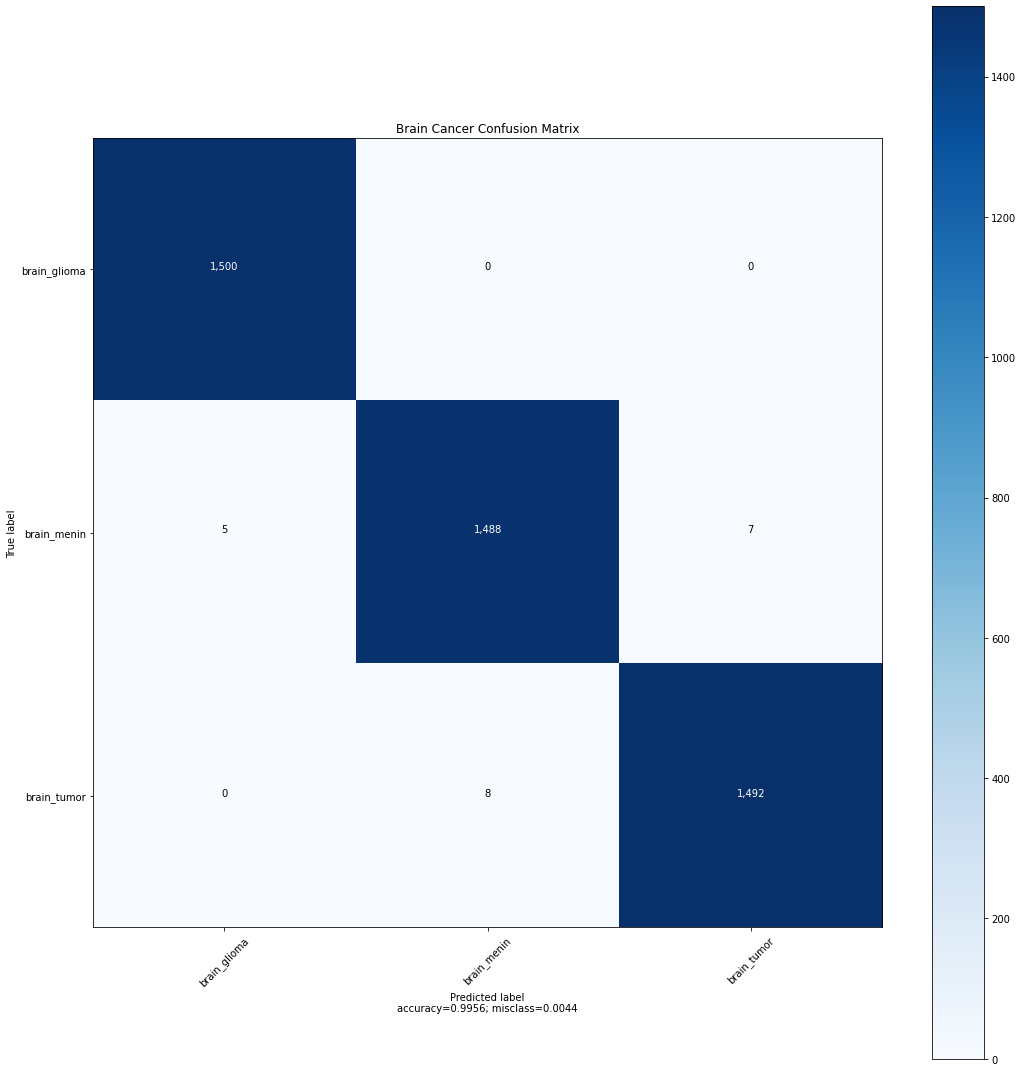

<Figure size 432x288 with 0 Axes>

In [9]:
mpath = r'/kaggle/input/multi-cancer/Multi Cancer'
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 7
lr = 0.001
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

